# Using the code to solve the Poisson-Boltzmann equation

The space charge model implemented in this code is one dimensional, with a series of discrete sites at values of $x$ over a given region. 
These $x$ coordinates, along with the segregation energies required as input for the solver can be generated using atomistic modelling of a given system.

The majority of the code used is stored externally and is imported in to the notebook, along with the standard python modules, numpy, pandas and matplotlib.

In [1]:
import os
os.getcwd()

import sys
sys.path.append('/Users/glw33/source/project')

from project.defect_species import Defect_Species
from project.set_of_sites import Set_of_Sites
from project.constants import boltzmann_eV
from project.onedefect_onedopant_calculations import *
from project.general_calculations import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

input_dir = 'input_data'
output_dir = 'output_data'

 ### Defining variables
Here the variables are defined. These are required for the calculation to run.

```alpha``` - is a damping parameter used to damp the updates to the potential during every iteration to help convergence and numerical stability.

```conv``` -  is the convergence limit that the difference between the calculated potential and the damped potential must be before convergence is accepted. 

```grid_x_min / grid_x_max``` - define the region either side of the grain boundary that will be included in the calculation.

```dielectric``` - The relative permittivity of the material. In this case Gd-doped CeO2.

```index``` - The grain boundary orientation selected for the calculation.

```b / c``` - The width and height of the cell used in the atomistic simulation when defect segreagtion energies were calculated. Specific to the grain boundary orientation.

```temp``` - Temperature (K).

In [2]:
alpha = 0.0005

conv = 1e-8
grid_x_min = -5e-8
grid_x_max = +5e-8

dielectric = 1

index = 111

b = 5e-9
c = 5e-9

temp = [773.15]

limits = [ grid_x_min, grid_x_max ]

### Defining system specific constants.

The code that is imported calculates the grain boundary properties for any system that has one mobile defect and one immobile defect. In the cell below the properties for a given system are defined. These properties include the following lists. The **valence** (defect charge), the **site labels** (site_1 / site_2 - labels defining the species that would be occupying the site in pure ceria), the **defect labels** (defect_1 / defect_2 - labels defining the defect species occupying the site in gadolinium doped ceria) and the **defect mole fractions**

The values are always in the order [ mobile defect property, immobile defect property ].
#### Example
To demonstrate how the system specific constants would be implemented using real data an example system of gadolinium doped ceria is shown.

```python
valence = [ +2.0, -1.0 ]
site labels = [ 'O', 'Ce' ]
defect_labels = [ 'Vo', 'Gd' ]
mole_fractions = [ [ 0.05, 0.2 ] ]
```

However for the purpose of this example notebook we are not using any particular system. The site labels are defined as site_1/site_2 and the defect labels are defined as defect_1/defect_2 with equal but opposite valence and equal mole fractions.

In [3]:
valence = [ +1.0, -1.0 ]
site_labels = ['site_1', 'site_2']
defect_labels = ['defect_1', 'defect_2']
mole_fractions = [ [ 0.2, 0.2 ] ]

When the calculation is run, the bulk mole fraction of each defect species in the output is less than the desired bulk mole fraction for each defect, therefore a correction is required to ensure that that bulk mole fraction of each defect in the output is what it should be. In the cell below, the desired mole fraction of the mobile defect and the percentage dopant concentration are defined. These are defined to select the relevent correction from the correction calculation. In this simple example, these are not used but must be defined to avoid an error.

In [4]:
desired_mobile_defect_mf = 0.2
percentage_dopant = 20

### Input data

Following this, the path to the data file is defined and stored in ```data```. 

In [5]:
data = '/Users/glw33/Documents/papers/Gd-CeO2_SC/supporting_information/examples/data_for_examples/example_data_2_one_seg_energies.txt'
#data = input_data + '/filename'
#data = "{}/filename".format( input_data )
#data = f'{input_data}/filename'



The input for the solver is a .txt file where each line in the file corresponds to a different site.

Each line in the .txt file needs to be a string containing the following information:

**Site label** - site_1 / site_2 - A label defining the species that would be occupying the site in pure ceria. 

** x coordinate ** - float - The x coordinate for the position of the site.

** Defect label ** - defect_1 / defect_2 -  A label defining the defect species occupying the site.

** Segregation energy ** The defect segregation energy for that defect occupying that site.

For example:

```
site_2   -2e-09   defect_2   0.0
site_1   -2e-09   defect_1   0.0
site_2   -1e-09   defect_2   0.0
site_1   -1e-09   defect_1   0.0
site_2   0        defect_2   0.0
site_1   0        defect_1   -1.0
site_1   1e-09    defect_1   0.0
site_2   1e-09    defect_2   0.0
site_1   2e-09    defect_1   0.0
site_2   2e-09    defect_2   0.0
```

In this example system, each $x$ coordinate on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings) has one positively charged defect (```defect_one```) and one negatively charged defect (```defect_2```). These defects are equal and opposite in their valence and therefore the system is charge neutral. For simplicity, all of the defects have a segregation energy of zero, except the central positively charged defect which has a segregation energy of -1.0 eV.

### Running the calculation

As described above, for a real system there would be an initialisation step whereby a correction is applied to the bulk mole fraction used as input to achieved the desired mole fraction in the output. This correction changes depending on the temperature of the simulation and therefore the calculation in run over a loop of the temperature and mole fraction zipped together. This is in place to allow the calculation to run over a list of different temperatures without any additional user input. 

```
for t, m in zip( temp, mole_fractions ):
```

Next the different defect species are defined using the ```Defect_Species``` class. This collects and stores the information about each defect, the defect label, the defect valence and the defect mole fraction.

```
defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
```

The input data file is opened.

```
data_file = open( data, 'r')
```

Each line is read from the opened input file and split into the different pieces of information. The site label, the $x$ coordinate, the defect label and the segregation energy providing the $x$ coordinate is in the range given by ```grid_x_min``` and ```grid_x_max```.

```
input_data = [ line.split() for line in data_file.readlines() ]
input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
```

The information is then passed into the ```site_from_input_file``` function, which creates a site using the ```Site``` class. The Site class collects and stored all of the information about each site and the defects at the site. It has the site label, the $x$ coordinate, ```defect_species``` at the site (which contains the defect label, defect valence and defect mole fraction)and the defect segregation energy. These sites are then collected and stored in a Set_of_Sites class which groups together the sites and is used for calculations involving all the sites as a whole system rather than calculations on the sites independently. 


```
all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
```

The next part of the code is optional. Space charge models typically consider dopant ions as either mobile or immobile. If the dopant ions are considered immobile, the model follows a Mott-Schottky approximation. If the dopant ions are considered mobile, the model follows a Gouy-Chapman approximation. This code includes both approximations. If ```fixed = True``` the mole fraction of the dopant ion is fixed to the bulk mole fraction throughout the iterations and therefore follows the Mott-Schottky approximation, simulating immobile dopant ions. If ```fixed = False ``` the dopant ions redistribute to their equilibrium positions, following the Gouy-Chapman approximation, simulating mobile dopant ions. The default setting is ```False```.

```
for site in all_sites.subset( 'site_2' ):
    site.defect_with_label('defect_2').fixed = False
```

Following this, the calculation is run using the ```calculate_GB_properties``` function. This returns the grid, the potential, the charge density, the resistivity ratio (note - only correct when using Mott-Schottky approximation), the equilibrium defect mole fractions and the bulk defect density. 

The ```calculate_GB_properties``` function works as follows.

1. The $x$ coordinates are selected from the sites and a numpy array is created from the unique values.
2. A grid is created using the ```Grid``` class. This includes the array of $x$ coordinates, b/c (the width and height of the cell used in the atomistic simulation) and the full set of sites ```all_aites```.
3. Another grid is created using the information for the mobile defects only. This is used for the resistivity calculations and only works when using the Mott-Shottky approximation. 
4. The potential and charge density are calculated. This uses a function ```calculation``` which takes arguments os ``` grid, conv, temp, alpha and boundary_conditions ```. The ```calculation``` function creates numpy arrays the same length as the grid including zeros for the potential (```phi```) and the charge density (```rho```). 

 **If ```boundary_conditions``` is set to ```dirichlet```**

5. The invertible matrix $A$ is created from the distances between each of the points on the grid. Initially the full matrix is created using ```scipy.sparse.diags```  and is then converted into a sparse tridiagonal matrix using ```scipy.sparse.csc_matrix``` and the calculation follows the finite difference approximation method defined above. 
6. The convergence is initialised as 1 and while it is larger than ```conv``` defined in the notebook the calculation will iterate. 
7. Using the ```phi``` array of zeros, the charge density is calculated at each site. Using the calculated value for the charge density at each site $\Phi = A^{-1}b$ is solved using ```scipy.linalg.spsolve```. This returns ```predicted_phi``` at each site, which is damped using $\alpha$ to become the new ```phi``` array. The convergence is updated using $\frac{ \sum_i ( ( \Phi_{predicted} - \Phi )^2 )}{L_{grid.x}}$ where $L_{grid.x}$ is the length of the grid.
8. Using the calculated potential values the defect density is calculated. The resistivity ratio (to be discussed later), and equilibrium defect mole fractions are then calculated. 

 ** If ```boundary_conditions``` is set to ```periodic```**
 
9. The calculation follows the cumulative sum method defined above.
10. The convergence is initialised as 1 and while it is larger than ```conv``` defined in the notebook the calculation will iterate. 
7. Using the ```phi``` array of zeros, the charge density is calculated at each site. Using the calculated value for the charge density at each site, ${\Phi}$ is recalculated using a cumulative sum, ```corrected_phi``` is defined as $\Phi + c $ with $c$ calculated using ```scipy.optimize.minimize_scalar``` allowing ```corrected_phi``` to be calculated. ```corrected_phi``` is damped using $\alpha$ to become the new ```phi``` array. The convergence is updated using $\frac{ \sum_i ( ( \Phi_{predicted} - \Phi )^2 )}{L_{grid.x}}$ where $L_{grid.x}$ is the length of the grid and the process is iterated until the convergence limit is met.
8. Using the calculated potential values the defect density is calculated. The resistivity ratio (to be discussed later), and equilibrium defect mole fractions are then calculated.

```
grid, phi, rho, probabilities, resistivity_ratio, defect_1_mole_fraction, defect_2_mole_fraction, bulk_density = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_mf, all_sites, site_labels )
```

As mentioned above, the data used for this first example has a series of sites which have $x$ coordinates on a regularly spaced grid (-50 nm to +50 nm with 1 nm spacings). Each site has one positively charged defect (defect_one) and one negatively charged defect (defect_2). These defects are equal and opposite in their valence and therefore the system is charge neutral. For simplicity, all of the defects have a segregation energy of zero, except the central positively charged defect which has a segregation energy of -1.0 eV. As there are positively charged defects and negatively charged defects at each site this particular system acts as though it is using a continuum model where any defect can occupy any site. This is particularly clear when the data is plotted and the potential, charge denisty and defect mole fraction profiles are smooth.

In this example, Dirichlet boundary conditions are enforced. This ensures the potential at the boundary sites is set to 0.0.  

In [6]:
# for t, m in zip( temp, mole_fractions ):
#     defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
#     data_file = open( data, 'r')
#     input_data = [ line.split() for line in data_file.readlines() ]
#     input_data = [ line for line in input_data if ( float(line[1]) > grid_x_min and float(line[1]) < grid_x_max ) ] 
#     all_sites = Set_of_Sites( [ site_from_input_file( line, defect_species ) for line in input_data ] )
#     for site in all_sites.subset( 'site_2' ):
#         site.defect_with_label('defect_2').fixed = False
#     grid, phi, rho, probabilities, resistivity_ratio, defect_1_mole_fraction, defect_2_mole_fraction, bulk_density, niter = calculate_GB_properties( t, grid_x_min, grid_x_max, b, c, index, alpha, conv, desired_mobile_defect_mf, all_sites, site_labels, 'dirichlet' )

boundary_conditions = 'dirichlet'

for t, m in zip( temp, mole_fractions ):
    defect_species = { l : Defect_Species( l, v, m ) for l, v, m in zip( defect_labels, valence, m) }
    
    all_sites = Set_of_Sites.set_of_sites_from_input_data( data, limits, defect_species )
    for site in all_sites.subset( 'site_2' ):
        site.defect_with_label('defect_2').fixed = False
        
    grid = Grid.grid_from_set_of_sites( all_sites, limits[0], limits[1], b, c )
    
    calculation_object = Calculation( grid, alpha, conv, t, boundary_conditions )
    
    calculation_object.solve()
    calculation_object.form_subgrids( site_labels )
    calculation_object.calculate_resistivity_ratio( desired_mobile_defect_mf )
    calculation_object.mole_fractions

 The potential, charge density and defect mole fractions can then be plotted as a function of their $x$ coordinate using ```matplotlib.pyplot```.

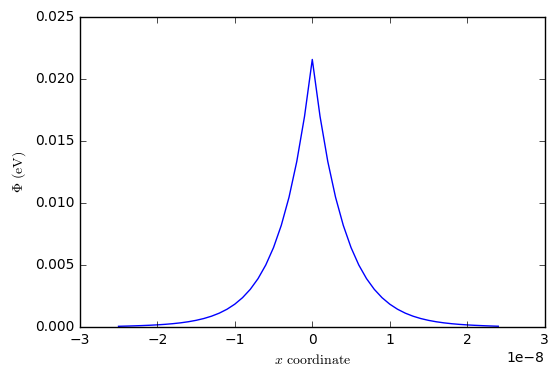

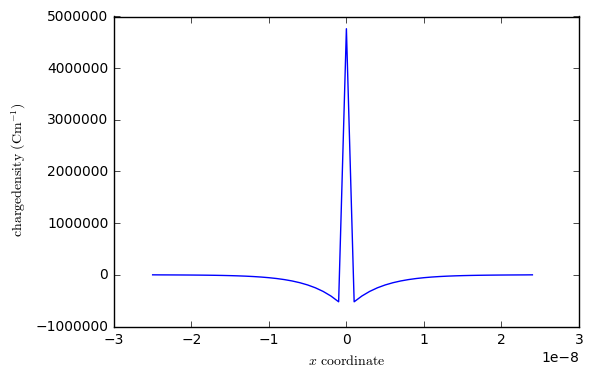

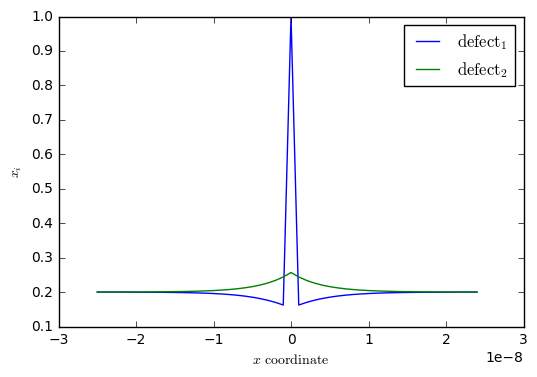

In [7]:
plt.plot(grid.x, calculation_object.phi)
plt.xlabel( '$x$ $\mathrm{coordinate}$' )

plt.ylabel('$\Phi$ $\mathrm{( eV )}$')
plt.show()

plt.plot(grid.x, calculation_object.rho)
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel(' $\mathrm{charge density}$ $(\mathrm{C m}^{-1})$')
plt.show()

plt.plot(grid.x, calculation_object.mf[site_labels[0]], label = '$\mathrm{defect_1}$')
plt.plot(grid.x, calculation_object.mf[site_labels[1]], label = '$\mathrm{defect_2}$')
plt.xlabel( '$x$ $\mathrm{coordinate}$'  )
plt.ylabel('$x_{i}$')
plt.legend()
plt.show()